In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
UEFA_COEFFS = {
    "epl": 26.821,
    "laliga": 23.250,
    "seriea": 21.187,
    "bundesliga": 18.421,
    "ligue1": 16.857,
    "eredivisie": 15.250
}

### 1. Data

In [3]:
df = pd.read_csv("final_data_new.csv")
df.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
df = df.dropna(how='any')

In [4]:
df.isnull().values.any()

False

In [5]:
df = df[df["Minutes"]>30]

In [6]:
most_expensive_players = df.sort_values(ascending=False, by="Market Value")
print(most_expensive_players[['Name', 'League','Age','Market Value']].head(10))

                 Name      League   Age  Market Value
675   Vinicius Junior      laliga  24.0         200.0
208    Erling Haaland         epl  24.0         200.0
394      Lamine Yamal      laliga  17.0         180.0
391     Kylian Mbappe      laliga  26.0         170.0
117       Bukayo Saka         epl  23.0         150.0
233     Florian Wirtz  bundesliga  21.0         140.0
556        Phil Foden         epl  24.0         130.0
31     Alexander Isak         epl  25.0         100.0
592           Rodrygo      laliga  24.0         100.0
397  Lautaro Martinez      seriea  27.0          95.0


In [7]:
top_xG = df.sort_values(ascending=False, by="xG: Expected Goals")
print(top_xG[['Name', 'League', 'Market Value', 'xG: Expected Goals']].head(10))

                 Name      League  Market Value  xG: Expected Goals
265     Goncalo Ramos      ligue1          45.0                1.04
208    Erling Haaland         epl         200.0                0.88
273        Harry Kane  bundesliga          90.0                0.83
620   Serhou Guirassy  bundesliga          40.0                0.81
434     Marco Asensio         epl          20.0                0.77
538   Ousmane Dembele      ligue1          75.0                0.75
672   Victor Boniface  bundesliga          45.0                0.75
442  Marko Arnautovic      seriea           3.5                0.72
391     Kylian Mbappe      laliga         170.0                0.71
487     Mohamed Salah         epl          55.0                0.69


### 2. Methodology

In [8]:
df["Goals-xG"] = df["Goals"] - df["xG: Expected Goals"]

In [9]:
scaler = MinMaxScaler()
coefficients = list(UEFA_COEFFS.values())
normalized_coeffs = scaler.fit_transform(np.array(coefficients).reshape(-1,1)).flatten()
league_strength_normalized = dict(zip(UEFA_COEFFS.keys(), normalized_coeffs))
df['League_Strength'] = df['League'].map(league_strength_normalized)

In [10]:
top_xg_ovp = df.sort_values(ascending=False, by="Goals-xG")
print(top_xg_ovp[['Name', 'League', 'Market Value', 'Goals-xG' ]].head(20))

                       Name      League  Market Value  Goals-xG
428           Malik Tillman  eredivisie          30.0      0.43
546           Patrik Schick  bundesliga          27.0      0.27
442        Marko Arnautovic      seriea           3.5      0.26
63         Anis Hadj Moussa  eredivisie          12.0      0.26
86              Assane Diao      laliga          25.0      0.25
452           Matheus Cunha         epl          55.0      0.24
32        Alexander Sorloth      laliga          25.0      0.24
35      Alexis Saelemaekers      seriea          17.0      0.24
9           Ademola Lookman      seriea          60.0      0.24
34    Alexis Claude Maurice  bundesliga          12.0      0.24
427           Malick Fofana      ligue1          25.0      0.24
633        Steven Skrzybski  bundesliga           1.0      0.23
359          Julian Alvarez      laliga          90.0      0.23
88              Ayoze Perez      laliga          10.0      0.23
556              Phil Foden         epl 

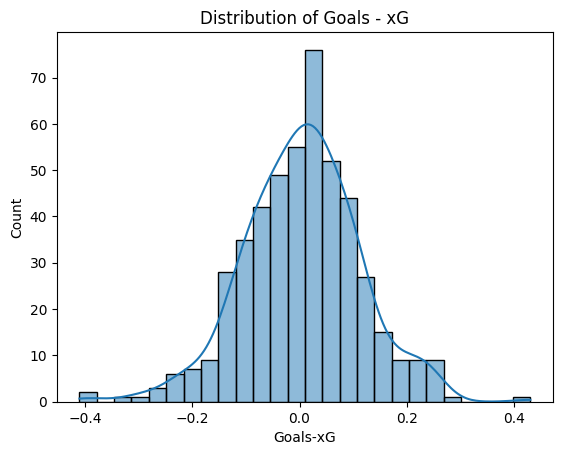

In [11]:
sns.histplot(df['Goals-xG'], kde=True)
plt.title('Distribution of Goals - xG')
plt.show()

In [12]:
print(df['Goals-xG'].describe())

count    481.000000
mean       0.004553
std        0.108174
min       -0.410000
25%       -0.060000
50%        0.010000
75%        0.070000
max        0.430000
Name: Goals-xG, dtype: float64


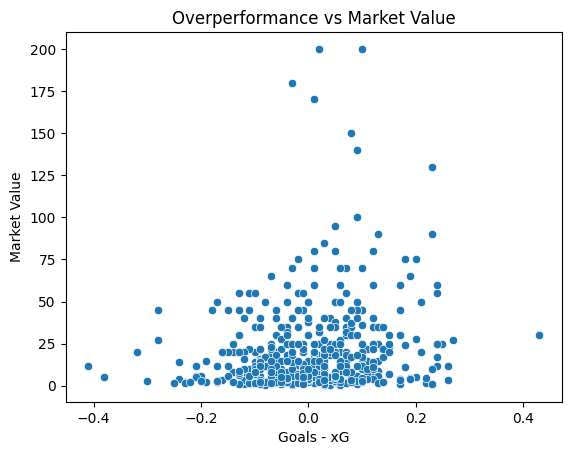

In [13]:
sns.scatterplot(x='Goals-xG', y='Market Value', data=df)
plt.title('Overperformance vs Market Value')
plt.xlabel('Goals - xG')
plt.ylabel('Market Value')
plt.show()

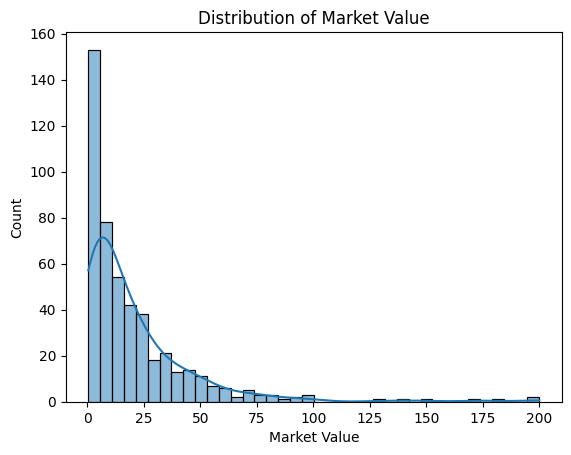

In [14]:
sns.histplot(df['Market Value'], kde=True)
plt.title('Distribution of Market Value')
plt.show()

In [15]:
df['Log_Market_Value'] = np.log(df['Market Value'])

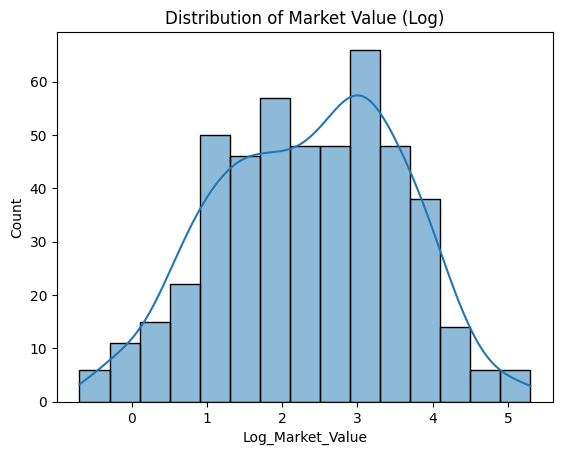

In [16]:
sns.histplot(df['Log_Market_Value'], kde=True, bins=15)
plt.title('Distribution of Market Value (Log)')
plt.show()

In [17]:
df.columns

Index(['Name', 'League', 'Goals', 'Assists', 'Non-Penalty Goals',
       'xG: Expected Goals', 'npxG: Non-Penalty xG',
       'xAG: Exp. Assisted Goals', 'Progressive Carries', 'Progressive Passes',
       'Progressive Passes Rec', 'Shots Total', 'Shots on Target',
       'Goals/Shot', 'npxG/Shot', 'xA: Expected Assists', 'Key Passes',
       'Through Balls', 'Crosses', 'Shot-Creating Actions',
       'Goal-Creating Actions', 'Shots on Target.1', 'Touches (Att 3rd)',
       'Touches (Att Pen)', 'Age', 'Market Value', 'Starting Eleven',
       'Minutes', 'Goal Involvement', 'Goals-xG', 'League_Strength',
       'Log_Market_Value'],
      dtype='object')

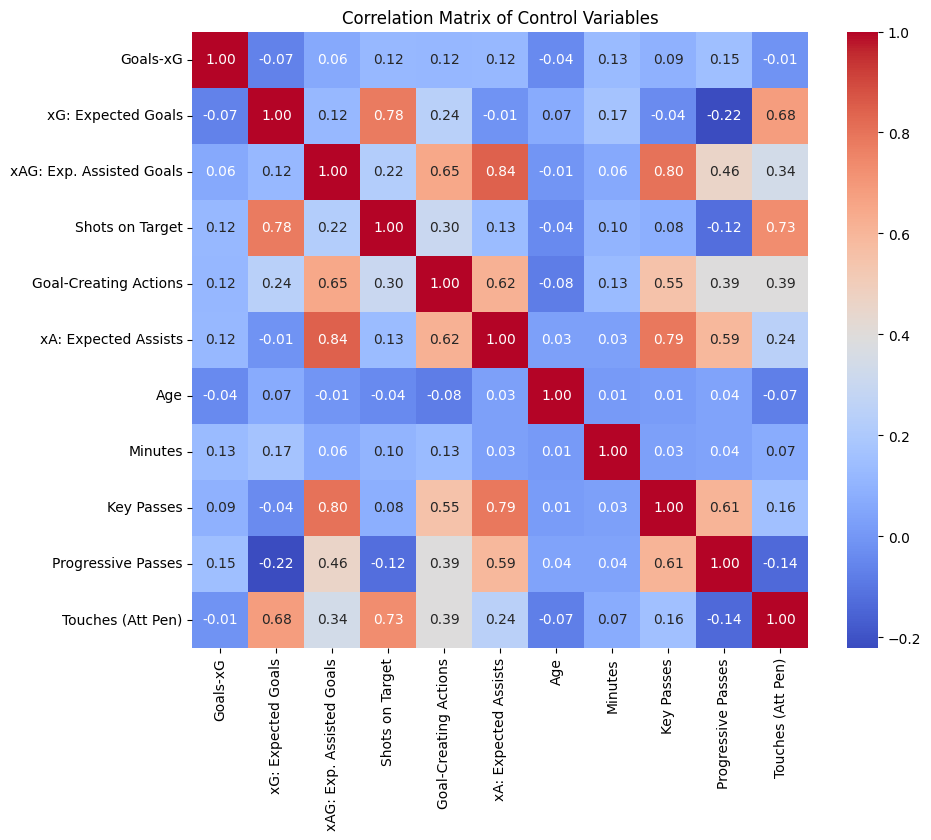

In [18]:
features = ['Goals-xG','xG: Expected Goals', 'xAG: Exp. Assisted Goals', 'Shots on Target', 'Goal-Creating Actions', 'xA: Expected Assists',
                 'Age', 'Minutes', 'Key Passes', 'Progressive Passes', 'Touches (Att Pen)']

corr_matrix = df[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Control Variables')
plt.show()

### 3. Interaction Terms ( Leave For Now )

In [19]:
# df['Age_X_League'] = df['League_Strength'] * df['Age']

### 3. Dummy PL Variable

In [58]:
df['isPl'] = (df['League'] == 'epl').astype(int)

In [26]:
df['Pl_X_League'] = df['isPl'] * df['Age']

### 4. Prediction

In [20]:
df.isnull().values.any()

False

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 481 entries, 0 to 700
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      481 non-null    object 
 1   League                    481 non-null    object 
 2   Goals                     481 non-null    float64
 3   Assists                   481 non-null    float64
 4   Non-Penalty Goals         481 non-null    float64
 5   xG: Expected Goals        481 non-null    float64
 6   npxG: Non-Penalty xG      481 non-null    float64
 7   xAG: Exp. Assisted Goals  481 non-null    float64
 8   Progressive Carries       481 non-null    float64
 9   Progressive Passes        481 non-null    float64
 10  Progressive Passes Rec    481 non-null    float64
 11  Shots Total               481 non-null    float64
 12  Shots on Target           481 non-null    float64
 13  Goals/Shot                481 non-null    float64
 14  npxG/Shot      

In [61]:
X = df[['Goals-xG','xG: Expected Goals','Goal-Creating Actions', 'Age', 'Minutes', 'League_Strength', 
        'Progressive Passes', 'Touches (Att Pen)', 
        # 'isPl',
        # 'Pl_X_League'
        ]]
y = df['Log_Market_Value']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Log_Market_Value   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     111.3
Date:                Wed, 30 Apr 2025   Prob (F-statistic):          1.36e-103
Time:                        16:56:48   Log-Likelihood:                -518.72
No. Observations:                 481   AIC:                             1055.
Df Residuals:                     472   BIC:                             1093.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.60

### VIF Test for Multicollinearity

In [63]:
X = df[['Goals-xG','xG: Expected Goals','Goal-Creating Actions', 'Age', 'Minutes', 'League_Strength', 
        'Progressive Passes', 'Touches (Att Pen)', 
        # 'isPl',
        # 'Pl_X_League'
        ]]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                 feature        VIF
0                  const  74.895568
1               Goals-xG   1.050186
2     xG: Expected Goals   2.094382
3  Goal-Creating Actions   1.593653
4                    Age   1.048913
5                Minutes   1.067950
6        League_Strength   1.021034
7     Progressive Passes   1.410793
8      Touches (Att Pen)   2.233812


### Residual Plot and Heteroskedasticity

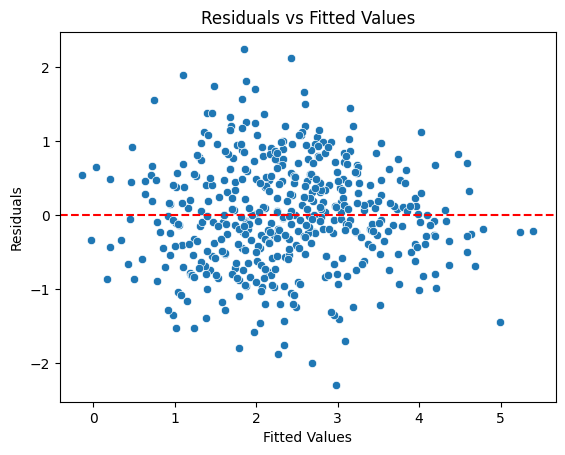

In [64]:
residuals = model.resid
fitted = model.fittedvalues

sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

In [65]:
from statsmodels.stats.diagnostic import het_breuschpagan

# y = dependent variable
# X = independent variables
from statsmodels.formula.api import ols
import statsmodels.api as sm

# if you've already run model = sm.OLS(y, X).fit()
bp_test = het_breuschpagan(model.resid, model.model.exog)

labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 15.41887519288316, 'LM-Test p-value': 0.05149451216662224, 'F-Statistic': 1.9539315232269931, 'F-Test p-value': 0.05053300224092823}


In [66]:
from statsmodels.stats.diagnostic import het_white

white_test = het_white(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

{'LM Statistic': 61.241628527944826, 'LM-Test p-value': 0.04360661647508923, 'F-Statistic': 1.4457099744693975, 'F-Test p-value': 0.03669506292616484}


### Using a robust model

In [ ]:
# robust_model = model.get_robustcov_results(cov_type='HC3') 
# print(robust_model.summary())

robust_model = sm.OLS(y, X).fit(cov_type='HC3')
print(robust_model.summary())

                            OLS Regression Results                            
Dep. Variable:       Log_Market_Value   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     141.3
Date:                Wed, 30 Apr 2025   Prob (F-statistic):          4.14e-120
Time:                        17:57:20   Log-Likelihood:                -518.72
No. Observations:                 481   AIC:                             1055.
Df Residuals:                     472   BIC:                             1093.
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.60

In [68]:
bp_test = het_breuschpagan(robust_model.resid, robust_model.model.exog)

labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 15.41887519288316, 'LM-Test p-value': 0.05149451216662224, 'F-Statistic': 1.9539315232269931, 'F-Test p-value': 0.05053300224092823}


In [47]:
white_test = het_white(robust_model.resid, robust_model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

{'LM Statistic': 61.241628527944826, 'LM-Test p-value': 0.04360661647508923, 'F-Statistic': 1.4457099744693975, 'F-Test p-value': 0.03669506292616484}


### Weighted Least Squares (WLS)

In [70]:
residuals = model.resid
weights = 1 / (residuals**2 + 1e-8)
# fitted = model.fittedvalues
# weights = 1 / (fitted**2)
wls_model = sm.WLS(y, X, weights=weights).fit()
print(wls_model.summary())

                            WLS Regression Results                            
Dep. Variable:       Log_Market_Value   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.108e+05
Date:                Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:08:39   Log-Likelihood:                -189.61
No. Observations:                 481   AIC:                             397.2
Df Residuals:                     472   BIC:                             434.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.61

In [49]:
bp_test = het_breuschpagan(wls_model.resid, wls_model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 15.269812454904118, 'LM-Test p-value': 0.05410663173617769, 'F-Statistic': 1.9344224594677115, 'F-Test p-value': 0.05315302481065352}


In [50]:
white_test = het_white(wls_model.resid, wls_model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

{'LM Statistic': 61.0638477565049, 'LM-Test p-value': 0.04503379229116959, 'F-Statistic': 1.4409028978463407, 'F-Test p-value': 0.0380324088033134}
